## Simulating dataset

* Obtaining 100 values corresponding to latent abilties of 100 users from a random normal distribution

In [102]:
import pandas as pd
import numpy as np
#from numpy.random import seed
#seed(1)

ltrait_new = np.random.normal(0, 1, size=100)
num_sim_users = ltrait_new.shape[0]
num_sim_items = len([0,1,2])
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

# of sim user: 100 
# of sim items: 3


* **In following:**

    **a.) tpm functions: outputs 3PL likelihood values of responding to all 3 items by particular user.**
    
    **b.) sim_data: outputs list of tuples containing values in format (user, question/item, response).**

In [103]:
def tpm(diff, latent, guess=0.001, desc=1):
    guess= 0.001 #[0.001]*3#for 3 items
    desc=1 #[1]*3 for 3 items
    prob_per_user = list()
    
    for d in diff:
        prob_per_user.append(guess+ (1- guess)*(np.exp(desc*(latent-d))/(1+np.exp(desc*(latent-d)))))
        
    return prob_per_user

In [104]:
def sim_data(l_trait):
    items= [0,1,2]
    data_li= list()
    difficulty= [-0.5,0,0.5]
    for idx, val in enumerate(l_trait):
        data_li= data_li+ list(zip([idx]*3, items, tpm(diff= difficulty, latent= val)))
    
    return data_li

In [105]:
df_cols = ['user','questions', 'response']#final dataframe cols

data_list = sim_data(ltrait_new)
df_sim = pd.DataFrame(data_list, columns=df_cols)
#df_sim = df_sim.loc[np.random.randint(0,df_sim.shape[0]-1, size=df_sim.shape[0])]#shuffling data
df_sim.head(5)

,user,questions,response
0,0,0,0.849011
1,0,1,0.773290
2,0,2,0.674184
3,1,0,0.650062
4,1,1,0.529880


In [5]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
121,40,1,0
258,86,0,1
227,75,2,0


**Saving the dataset as CSV for later use with keras:**

In [6]:
#df_sim.to_csv('simulated_data.csv', index=False)

**Saving the dataset in format of R**
* Following dataset will be used to obtain coefficients from R tpm
* table array represent users along rows & questions/items across columns in progression and contain a response value at particular index say (i,j).

In [7]:
table_arr= np.zeros((num_sim_users,num_sim_items), dtype=int)

for user, item, resp in data_list:
    table_arr[user,item]= np.round(resp)

df_Rtable = pd.DataFrame(table_arr)
df_Rtable.head(4)

,0,1,2
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0


In [8]:
#df_Rtable.to_csv('simulated_data.dat', sep=' ', index=False, header= None)#Saves a .dat file in pwd

### Now using above simulated dataset to first train a keras_3PL & then R_tpm to draw comparison

#### Defining and Training a keras model with above simulated dataset

In [9]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [10]:
df_sim= pd.read_csv('simulated_data.csv')
df_sim.head(3)

,user,questions,response
0,92,0,1
1,86,2,1
2,57,1,1


In [11]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

shape of simulated x_train_user: (285, 100) 
shape of simulated  x_train_questions: (285, 3) 
shape of simulated  y_train: (285,)


## 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`

In [12]:
from keras import backend as K
from keras.layers import Lambda
from keras import regularizers
from keras import initializers
from keras.layers import Activation
from keras import constraints

In [188]:
user_input_layer = Input(shape=(x_train_user.shape[1],), name= 'user_id')#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],), name='questions/items')#bottom half of input

#1. kernel init set to RandomNorm(0,1), kernel regularizer set to l2
latent_trait = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        kernel_regularizer=regularizers.l2(0.01), name='latent_trait')(user_input_layer)

#2. kernel init set to RandomNorm(0,1),
difficulty_level = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        name='difficulty_level')(quest_input_layer)

#3. kernel init set to RandomNorm(1,1),
discrimination_param = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=1, stddev=1.0, seed=None),
        kernel_constraint= constraints.NonNeg(),
        name='disc_param')(quest_input_layer)

#4. should add Sigmoid activation-- ?
guess_param = Dense(1, use_bias=False,
                    kernel_initializer= initializers.RandomUniform(minval=-3.5, maxval=-2.5, seed=None),
                    activation='sigmoid', name='guessing_param')(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract(name='latent_diff_sub')([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply(name='disc_param_inter.')([latent_difficulty_subtract, 
                                                    discrimination_param])

#5. Sigmoid positioning corrected as per 3PL expression
sigmoid_layer= Activation('sigmoid', name='Sigmoid_func')(disc_param_interaction)


guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x, name='guess_param_inter.')(guess_param)


guess_param_interaction= keras.layers.Multiply(name='disc/guess_param_inter.')([sigmoid_layer,
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add(name='guess_param_inter/add')([guess_param, guess_param_interaction])


#6. changed activation to just linear
prediction_output = Dense(1, trainable=False, use_bias=False,kernel_initializer=keras.initializers.Ones(), name='prediction_layer')(guess_param_interaction)


model3_sim = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3_sim.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [189]:
model3_sim.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            3           questions/items[0][0]            
____________________________________________________________________________________________

In [15]:
history= model3_sim.fit(x=[x_train_user,x_train_questions], y=y_train, batch_size=16, epochs=256, verbose=0, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.


* Train Vs. Validation loss curves for simulated dataset

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model" with sim_data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

<Figure size 640x480 with 1 Axes>

### Obtaining underlying trained 3pl parameters from keras model

In [17]:
for idx in [2,3,5,6]:
    print('layer no: {} is named: {}'.format(idx, model3_sim.layers[idx].name))

layer no: 2 is named: latent_trait
layer no: 3 is named: difficulty_level
layer no: 5 is named: disc_param
layer no: 6 is named: guessing_param


In [18]:
latent_trait_parameters = model3_sim.layers[2].get_weights()[0]#latent trait for 500 users
difficulty_level_parameters= model3_sim.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= model3_sim.layers[5].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3_sim.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

In [19]:
difficulty_level_parameters

array([[-0.5725935 ],
       [-1.5636436 ],
       [ 0.44383195]], dtype=float32)

In [20]:
discrimination_parameters

array([[1.5333399 ],
       [0.19633137],
       [2.9944398 ]], dtype=float32)

In [21]:
pseudo_guess_parameters = np.exp(pseudo_guess_parameters)/(1+ np.exp(pseudo_guess_parameters))
pseudo_guess_parameters#New after sigmoid(weights)

array([[0.05725337],
       [0.05237949],
       [0.0708916 ]], dtype=float32)

### Loading R's 3PL model paramters from simulated dataset for comparison


In [22]:
coeff = pd.read_csv('simulated_data_r_coeffs.csv')
coeff.head(3)

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.048993,-0.539199,23.963986
1,V2,0.000008,0.044664,21.340652
2,V3,0.000003,0.695396,18.530009


In [23]:
r_params_cols =list(coeff.columns)
r_params_cols#columns from R's dataframe

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

### Table representation of param values from keras Vs. R

In [24]:
rel_items= list(range(1, df_sim['questions'].nunique()+1))

In [25]:
df_table= pd.DataFrame({'Questions': rel_items, 'Difficulty-keras': difficulty_level_parameters.reshape(-1),
 'Difficulty-R':coeff[r_params_cols[2]].values, 'Discrimination-keras':discrimination_parameters.reshape(-1),
 'Discrimination-R':coeff[r_params_cols[-1]].values, 'Guess-keras':pseudo_guess_parameters.reshape(-1),
 'Guess-R':coeff[r_params_cols[2]].values})
df_table.head(5)

,Questions,Difficulty-keras,Difficulty-R,Discrimination-keras,Discrimination-R,Guess-keras,Guess-R
0,1,-0.572594,-0.539199,1.533340,23.963986,0.057253,-0.539199
1,2,-1.563644,0.044664,0.196331,21.340652,0.052379,0.044664
2,3,0.443832,0.695396,2.994440,18.530009,0.070892,0.695396


In [26]:
normalized_diff_r=coeff[r_params_cols[2]]#/coeff[r_params_cols[2]].sum()
normalized_diff_r#new difficulty vals from R

0   -0.539199
1    0.044664
2    0.695396
Name: Dffclt, dtype: float64

## Scatterplots

### 1. Difficulty vals from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y

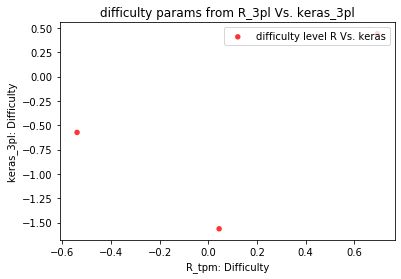

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (difficulty_level_parameters.reshape(-1), normalized_diff_r.values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="difficulty level R Vs. keras")
plt.title('difficulty params from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: Difficulty')
plt.xlabel('R_tpm: Difficulty')
plt.legend(loc=1)

plt.show()

### 2. Discrimination vals from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y

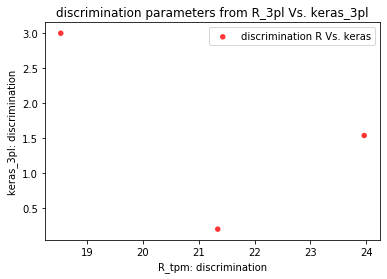

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (discrimination_parameters, coeff[r_params_cols[-1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="discrimination R Vs. keras")
plt.title('discrimination parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: discrimination')
plt.xlabel('R_tpm: discrimination')

plt.legend(loc=1)
plt.show()

### 3. Guessing param values from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y


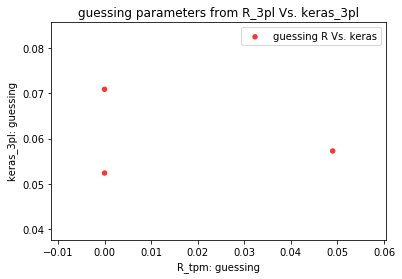

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (pseudo_guess_parameters, coeff[r_params_cols[1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="guessing R Vs. keras")
plt.title('guessing parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: guessing')
plt.xlabel('R_tpm: guessing')

plt.legend(loc=1)
plt.show()

## Item characteristic curves for all 3 items from simulated dataset with R tpm

In [30]:
def logit_func(lat_values):#c:guess, a:descrimination, b:difficulty
    prob = list()
    prob.append(c+ (1-c)*(np.exp(a*(lat_values-b))/(1+np.exp(a*(lat_values-b)))))#Vectorised implementation
    #for val in lat_values:
    #    prob.append(c+ (1-c)*(np.exp(a*(val-b))/(1+np.exp(a*(val-b)))))
    return prob

In [31]:
x = np.linspace(-4,4, num=num_sim_users)#value count for x axis

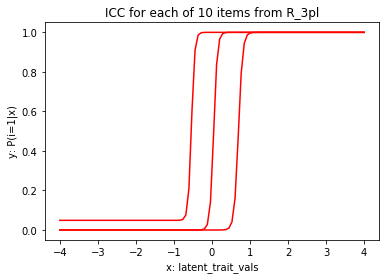

In [32]:
for i in range(coeff.shape[0]):
    c= coeff[r_params_cols[1]].iloc[i]#values of item 6 from R's dataframe
    a= coeff[r_params_cols[-1]].iloc[i]
    b= coeff[r_params_cols[2]].iloc[i]
    vals_r= logit_func(x)
    plt.plot(x,vals_r[0], 'r')

plt.title('ICC for each of 10 items from R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()

## Item characteristic curves for all items from simulated dataset with keras 3PL

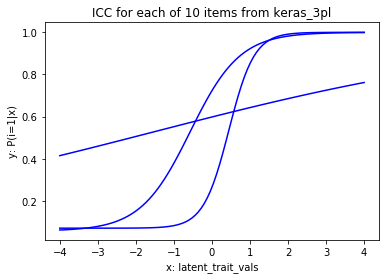

In [33]:
for i in range(len(rel_items)):#10 items
    c= pseudo_guess_parameters[i]#values for item 6 from keras 3pl params
    a= discrimination_parameters[i]
    b= difficulty_level_parameters[i]
    vals_keras= logit_func(x)
    plt.plot(x,vals_keras[0], 'b')

plt.title('ICC for each of 10 items from keras_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()#for mean=0 stdDev=1

_____________________

### Adding additional user/item/response records to exisiting data using binomial prob. distribution

In [34]:
c_probs= pd.read_csv('simulated_data_c_probs.csv')
c_probs.head(3)

,user,questions,response
0,92,0,0.556639
1,86,2,0.539308
2,57,1,0.674226


In [35]:
np.random.binomial(5, c_probs['response'].iloc[0],3)#For 3 trails of 5 exps/appraoch each 

array([1, 3, 3])

In [76]:
c_mat= c_probs.values
c_mat[:8]

array([[92.        ,  0.        ,  0.55663905],
       [86.        ,  2.        ,  0.53930795],
       [57.        ,  1.        ,  0.67422594],
       [97.        ,  2.        ,  0.10632712],
       [48.        ,  0.        ,  0.65960186],
       [22.        ,  1.        ,  0.33387805],
       [96.        ,  2.        ,  0.54257647],
       [87.        ,  0.        ,  0.68642433]])

In [93]:
np.where(c_mat[:,0]==57)

(array([  2,  39,  45, 229, 299]),)

In [77]:
np.where(c_mat[:,0]==92)

(array([  0,  50, 128, 213]),)

* Since there are only 3 items to uniquely respond, therefore each user might have responded to same question mutiple times.

### Following function appends new records to existing data

In [172]:
def add_data(array, points_per_user):
    array_li= array.tolist()
    dock_list=list()#to hold new lists
    for u, i, prob in array_li:
        count_success = np.random.binomial(points_per_user, prob)
        
        for idx in range(count_success):
            dock_list.append([u,i, prob])
        for idx in range(points_per_user-count_success):
            dock_list.append([u,i, 1-prob])
        
    array_li+=dock_list
    return np.array(array_li)

In [174]:
c_mat.shape#Current shape without additions of new rows/records

(300, 3)

* **Adding 10 bernouli experiments per user for a single sequence/trial**

In [177]:
abc= add_data(c_mat, 10)

In [185]:
df_abc = pd.DataFrame(abc, columns=df_cols)
df_abc

,user,questions,response
0,92.0,0.0,0.556639
1,86.0,2.0,0.539308
2,57.0,1.0,0.674226
3,97.0,2.0,0.106327
4,48.0,0.0,0.659602
...,...,...,...
3295,57.0,2.0,0.443326
3296,57.0,2.0,0.443326
3297,57.0,2.0,0.443326
3298,57.0,2.0,0.443326


* New records added

In [184]:
df_abc.describe()

,user,questions,response
count,3300.00000,3300.000000,3300.000000
mean,51.04000,0.973333,0.587002
std,28.62563,0.844297,0.195096
min,1.00000,0.000000,0.038512
25%,26.75000,0.000000,0.443326
50%,50.00000,1.000000,0.585409
75%,77.00000,2.000000,0.726413
max,99.00000,2.000000,0.961488


### Now training keras 3PL with new dataset

* **Converting responses to 0s & 1s**

In [186]:
df_abc['response']=df_abc['response'].apply(lambda x: int(np.round(x)))
df_abc.head(3)

,user,questions,response
0,92.0,0.0,1
1,86.0,2.0,1
2,57.0,1.0,1


* Train & test splitting data

In [187]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_abc[df_cols[:-1]], df_abc[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

shape of simulated x_train_user: (3135, 100) 
shape of simulated  x_train_questions: (3135, 3) 
shape of simulated  y_train: (3135,)


In [190]:
model3_sim.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])
model3_sim.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            3           questions/items[0][0]            
____________________________________________________________________________________________

In [191]:
history= model3_sim.fit(x=[x_train_user,x_train_questions], y=y_train, batch_size=64, epochs=256, verbose=1, validation_split=0.2)

Train on 2508 samples, validate on 627 samples
Epoch 1/256
2508/2508 [==============================] - 0s 52us/step - loss: 1.7185 - mae: 0.4784 - accuracy: 0.6288 - val_loss: 1.7072 - val_mae: 0.4787 - val_accuracy: 0.6364
Epoch 2/256
2508/2508 [==============================] - 0s 12us/step - loss: 1.7001 - mae: 0.4780 - accuracy: 0.6328 - val_loss: 1.6895 - val_mae: 0.4786 - val_accuracy: 0.6364
Epoch 3/256
2508/2508 [==============================] - 0s 15us/step - loss: 1.6824 - mae: 0.4779 - accuracy: 0.6328 - val_loss: 1.6721 - val_mae: 0.4785 - val_accuracy: 0.6316
Epoch 4/256
2508/2508 [==============================] - 0s 13us/step - loss: 1.6650 - mae: 0.4777 - accuracy: 0.6332 - val_loss: 1.6551 - val_mae: 0.4783 - val_accuracy: 0.6188
Epoch 5/256
2508/2508 [==============================] - 0s 15us/step - loss: 1.6479 - mae: 0.4775 - accuracy: 0.6344 - val_loss: 1.6384 - val_mae: 0.4782 - val_accuracy: 0.6140
Epoch 6/256
2508/2508 [==============================] - 0s 13u

2508/2508 [==============================] - 0s 12us/step - loss: 1.1534 - mae: 0.4682 - accuracy: 0.6415 - val_loss: 1.1528 - val_mae: 0.4704 - val_accuracy: 0.6252
Epoch 47/256
2508/2508 [==============================] - 0s 12us/step - loss: 1.1450 - mae: 0.4679 - accuracy: 0.6415 - val_loss: 1.1445 - val_mae: 0.4701 - val_accuracy: 0.6252
Epoch 48/256
2508/2508 [==============================] - 0s 11us/step - loss: 1.1367 - mae: 0.4676 - accuracy: 0.6407 - val_loss: 1.1364 - val_mae: 0.4698 - val_accuracy: 0.6252
Epoch 49/256
2508/2508 [==============================] - 0s 12us/step - loss: 1.1286 - mae: 0.4673 - accuracy: 0.6451 - val_loss: 1.1284 - val_mae: 0.4695 - val_accuracy: 0.6252
Epoch 50/256
2508/2508 [==============================] - 0s 12us/step - loss: 1.1206 - mae: 0.4670 - accuracy: 0.6451 - val_loss: 1.1204 - val_mae: 0.4692 - val_accuracy: 0.6252
Epoch 51/256
2508/2508 [==============================] - 0s 13us/step - loss: 1.1126 - mae: 0.4667 - accuracy: 0.6451

2508/2508 [==============================] - 0s 13us/step - loss: 0.8805 - mae: 0.4541 - accuracy: 0.6730 - val_loss: 0.8833 - val_mae: 0.4568 - val_accuracy: 0.6619
Epoch 92/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.8764 - mae: 0.4538 - accuracy: 0.6730 - val_loss: 0.8792 - val_mae: 0.4566 - val_accuracy: 0.6619
Epoch 93/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.8723 - mae: 0.4536 - accuracy: 0.6730 - val_loss: 0.8752 - val_mae: 0.4563 - val_accuracy: 0.6619
Epoch 94/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.8683 - mae: 0.4533 - accuracy: 0.6730 - val_loss: 0.8713 - val_mae: 0.4561 - val_accuracy: 0.6619
Epoch 95/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.8644 - mae: 0.4531 - accuracy: 0.6730 - val_loss: 0.8674 - val_mae: 0.4558 - val_accuracy: 0.6619
Epoch 96/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.8606 - mae: 0.4528 - accuracy: 0.6730

Epoch 137/256
2508/2508 [==============================] - 0s 12us/step - loss: 0.7467 - mae: 0.4447 - accuracy: 0.6722 - val_loss: 0.7499 - val_mae: 0.4472 - val_accuracy: 0.6746
Epoch 138/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.7448 - mae: 0.4447 - accuracy: 0.6722 - val_loss: 0.7479 - val_mae: 0.4471 - val_accuracy: 0.6746
Epoch 139/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.7429 - mae: 0.4446 - accuracy: 0.6722 - val_loss: 0.7460 - val_mae: 0.4469 - val_accuracy: 0.6746
Epoch 140/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.7411 - mae: 0.4444 - accuracy: 0.6722 - val_loss: 0.7442 - val_mae: 0.4468 - val_accuracy: 0.6746
Epoch 141/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.7392 - mae: 0.4443 - accuracy: 0.6722 - val_loss: 0.7423 - val_mae: 0.4467 - val_accuracy: 0.6746
Epoch 142/256
2508/2508 [==============================] - 0s 12us/step - loss: 0.7374 - mae: 0.4442

2508/2508 [==============================] - 0s 13us/step - loss: 0.6850 - mae: 0.4403 - accuracy: 0.6722 - val_loss: 0.6877 - val_mae: 0.4423 - val_accuracy: 0.6746
Epoch 183/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6841 - mae: 0.4403 - accuracy: 0.6722 - val_loss: 0.6868 - val_mae: 0.4423 - val_accuracy: 0.6746
Epoch 184/256
2508/2508 [==============================] - 0s 12us/step - loss: 0.6832 - mae: 0.4404 - accuracy: 0.6722 - val_loss: 0.6859 - val_mae: 0.4422 - val_accuracy: 0.6746
Epoch 185/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6823 - mae: 0.4403 - accuracy: 0.6722 - val_loss: 0.6850 - val_mae: 0.4422 - val_accuracy: 0.6746
Epoch 186/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6814 - mae: 0.4402 - accuracy: 0.6722 - val_loss: 0.6841 - val_mae: 0.4421 - val_accuracy: 0.6746
Epoch 187/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6806 - mae: 0.4402 - accuracy: 0

2508/2508 [==============================] - 0s 13us/step - loss: 0.6557 - mae: 0.4383 - accuracy: 0.6722 - val_loss: 0.6581 - val_mae: 0.4398 - val_accuracy: 0.6746
Epoch 228/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6552 - mae: 0.4381 - accuracy: 0.6722 - val_loss: 0.6576 - val_mae: 0.4397 - val_accuracy: 0.6746
Epoch 229/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6548 - mae: 0.4380 - accuracy: 0.6722 - val_loss: 0.6572 - val_mae: 0.4397 - val_accuracy: 0.6746
Epoch 230/256
2508/2508 [==============================] - 0s 13us/step - loss: 0.6544 - mae: 0.4380 - accuracy: 0.6722 - val_loss: 0.6568 - val_mae: 0.4397 - val_accuracy: 0.6746
Epoch 231/256
2508/2508 [==============================] - 0s 15us/step - loss: 0.6540 - mae: 0.4380 - accuracy: 0.6722 - val_loss: 0.6564 - val_mae: 0.4397 - val_accuracy: 0.6746
Epoch 232/256
2508/2508 [==============================] - 0s 14us/step - loss: 0.6536 - mae: 0.4380 - accuracy: 0

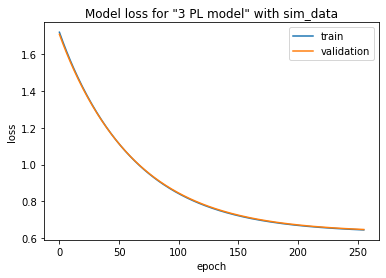

In [192]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model" with sim_data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

In [194]:
latent_trait_parameters = model3_sim.layers[2].get_weights()[0]#latent trait for 500 users
difficulty_level_parameters= model3_sim.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= model3_sim.layers[5].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3_sim.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

### Tabular data b/w Keras Vs. R

In [195]:
df_table= pd.DataFrame({'Questions': rel_items, 'Difficulty-keras': difficulty_level_parameters.reshape(-1),
 'Difficulty-R':coeff[r_params_cols[2]].values, 'Discrimination-keras':discrimination_parameters.reshape(-1),
 'Discrimination-R':coeff[r_params_cols[-1]].values, 'Guess-keras':pseudo_guess_parameters.reshape(-1),
 'Guess-R':coeff[r_params_cols[2]].values})
df_table.head(5)

,Questions,Difficulty-keras,Difficulty-R,Discrimination-keras,Discrimination-R,Guess-keras,Guess-R
0,1,-0.974313,-0.539199,0.789796,23.963986,-3.332122,-0.539199
1,2,-0.837232,0.044664,0.691309,21.340652,-2.982681,0.044664
2,3,-0.859831,0.695396,0.622291,18.530009,-2.507468,0.695396


### Item characteristic curves for all items from new simulated dataset with keras 3PL

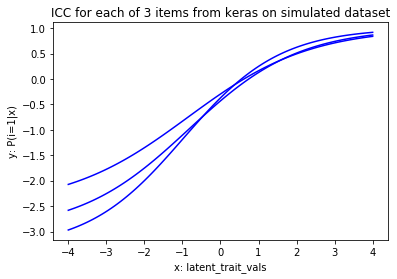

In [197]:
x = np.linspace(-4,4, num=num_sim_users)#value count for x axis

for i in range(len(rel_items)):#10 items
    c= pseudo_guess_parameters[i]#values for item 6 from keras 3pl params
    a= discrimination_parameters[i]
    b= difficulty_level_parameters[i]
    vals_keras= logit_func(x)
    plt.plot(x,vals_keras[0], 'b')

plt.title('ICC for each of 3 items from keras on simulated dataset')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()#for mean=0 stdDev=1

________________

* **Questions:**

##### 1.

In [101]:
#represents size 100 = number of users & each user approaches
# to Q0 10 times with response(Success) probability 55%?
probs= np.random.binomial(10, 0.55, size= 100)
which_user_responds_Q1 = np.where(probs>=9)#which users respond to Q1 maximum times
which_user_responds_Q1#Now add (34, 0, 0.55), (38, 0, 0.55), (79, 0, 0.55) to dataset

(array([34, 38, 79]),)

##### 2.

In [106]:
#represents size 100 = number of users & each user tries to respond
#to 3 questions with response(Success) probability 55%?
probs= np.random.binomial(3,0.55,size= 100) 
probs#Since every user responses to all 3 questions
#Now for 1st user corrsponding to distribution output;
#add (0, 0, 0.55),(0, 1, 0.55), (0, 2, 0.45) to dataset

array([2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2,
       2, 0, 2, 2, 3, 1, 2, 2, 0, 3, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2,
       3, 3, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 3, 2, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 3, 1, 2, 1, 2, 2, 3, 1, 1])